In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import *

torch.manual_seed(1234)

lr = 2e-4
EPS = 1e-10
device = 'cuda:0'

max_len = {
    20: 2,
    100: 4,
    500: 9
}

In [2]:
def train_instance(model, optimizer, n, k_sparse, n_ants):
    model.train()
    coor = torch.rand(size=(n, 2), device=device)
    pyg_data, distances, prizes = gen_pyg_data(coor, k_sparse)
    heu_mat = model.reshape(pyg_data, model(pyg_data)) + EPS
    
    aco = ACO(distances, prizes, max_len[n], n_ants, heuristic=heu_mat, device=device)
    objs, log_probs_list = aco.sample()
    objs = torch.stack(objs)
    baseline = objs.mean()
    reinforce_loss = 0
    for ant in range(n_ants):
        obj = objs[ant]
        log_probs = torch.stack(log_probs_list[ant])
        ant_loss = (baseline-obj) * log_probs.sum() 
        reinforce_loss += ant_loss
    reinforce_loss /= aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(model, instance, k_sparse, n_ants):
    model.eval()
    pyg_data, distances, prizes = instance
    heu_mat = model.reshape(pyg_data, model(pyg_data)) + EPS
    aco = ACO(distances, prizes, max_len[len(prizes)], n_ants, heuristic=heu_mat, device=device)
    objs, log_probs_list = aco.sample()
    objs = torch.stack(objs)
    baseline = objs.mean()
    best_sample_obj = objs.max()
    return baseline.item(), best_sample_obj.item()

In [3]:
def train_epoch(n, n_ants, k_sparse, steps_per_epoch, net, optimizer):
    for _ in range(steps_per_epoch):
        train_instance(net, optimizer, n, k_sparse, n_ants)

@torch.no_grad()
def validation(n_ants, k_sparse, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best = 0, 0
    for instance in val_dataset:
        bl, sample_best = infer_instance(net, instance, k_sparse, n_ants)
        sum_bl += bl
        sum_sample_best += sample_best

    n_val = len(val_dataset)
    avg_bl, avg_sample_best = sum_bl/n_val, sum_sample_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best))
    
    return avg_bl, avg_sample_best

In [4]:
def train(problem_size, k_sparse, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(problem_size, k_sparse, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj."])
    
    avg_bl, avg_best = validation(n_ants, k_sparse, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(problem_size, n_ants, k_sparse, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best = validation(n_ants, k_sparse, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/op/op{problem_size}.pt')

Learn heuristic for OP20: 

total training duration: 88.33110642433167
epoch -1: (2.2486753106117248, 3.4400942802429197)
epoch 0: (2.773358484109243, 3.866134683291117)
epoch 1: (3.5034384727478027, 4.461791300773621)
epoch 2: (3.9041426817576093, 4.665407379468282)
epoch 3: (3.888053131103516, 4.673074102401733)
epoch 4: (4.006972312927246, 4.7674578666687015)


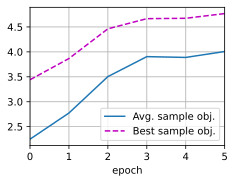

In [18]:
n_node, n_ants = 20, 20
steps_per_epoch = 64
k_sparse = 10
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for OP100:

total training duration: 1544.519012928009
epoch -1: (8.252378114064534, 13.410329914093017)
epoch 0: (17.360949897766112, 23.041892369588215)
epoch 1: (24.45846087137858, 28.417750740051268)
epoch 2: (22.559928925832114, 27.07690575917562)
epoch 3: (23.996270751953126, 28.97595272064209)
epoch 4: (23.483836205800376, 27.718730417887368)


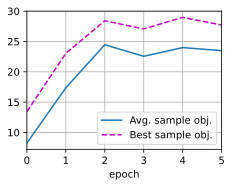

In [19]:
n_node, n_ants = 100, 50
steps_per_epoch = 128
k_sparse = 20
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for OP500:

total training duration: 7873.475706100464
epoch -1: (29.378547286987306, 43.7343936920166)
epoch 0: (99.77936986287435, 114.07257563273112)
epoch 1: (126.44067993164063, 138.71912536621093)
epoch 2: (130.9758046468099, 147.23273213704428)
epoch 3: (132.11336924235027, 147.44205525716146)
epoch 4: (137.09325663248697, 150.41048940022787)


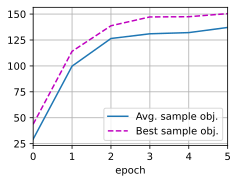

In [5]:
n_node, n_ants = 500, 50
steps_per_epoch = 128
k_sparse = 50
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)